# Mecánica Pulmonar: Análisis sin Surfactante

## 1. Sin Surfactante

### Energía Total (Muy Esquemática)

La funcional de energía potencial total del sistema se expresa como:

$$\Pi_0[\chi] = \int_{\Omega_0} W(F)\,dV - \int_{\Omega_t} p_{\text{alv}}\, dV - \int_{\Omega_0} \rho_0\, \mathbf{g}\cdot \chi\, dV - \int_{\Gamma_{\text{ext},0}} \mathbf{t}_{\text{pleural}}\cdot \chi\, dA_0$$

#### Componentes de la Funcional:

| Término | Símbolo | Descripción |
|---------|---------|-------------|
| **Deformación hiperelástica** | $W(F)$ | Energía de deformación (Neo-Hooke, etc.) |
| **Presión alveolar** | $p_{\text{alv}}$ | Presión interna en los alvéolos (airway pressure) |
| **Gravedad** | $\mathbf{g}$ | Campo gravitacional |
| **Tracción pleural** | $\mathbf{t}_{\text{pleural}}$ | Tracción en la superficie externa (pleural) |

---

## 2. Configuración de Equilibrio sin Surfactante

La configuración de equilibrio $\chi_0$ se obtiene como la solución del problema variacional que minimiza $\Pi_0[\chi]$.

### Ecuación de Equilibrio en el Volumen

En el interior del tejido pulmonar $\Omega_0$, se cumple la ecuación de balance de momentum:

$$\text{Div}_X\,P(F) + \rho_0\,\mathbf{g} = \mathbf{0} \quad\text{en } \Omega_0$$

donde:
- $\text{Div}_X$ es la divergencia respecto a las coordenadas materiales $X$
- $P(F) = \frac{\partial W}{\partial F}$ es el **tensor de tensiones de Piola** (o primer tensor de esfuerzos de Piola-Kirchhoff)
- $\rho_0$ es la densidad material
- $\mathbf{g}$ es el vector aceleración gravitacional

### Condiciones de Frontera

#### En la Superficie Alveolar Interna ($\Gamma_{\text{alv},0}$)

En el borde del tejido en contacto directo con el aire alveolar, se aplica:

$$P(F)\,\mathbf{N} = -p_{\text{alv}}\, J\,F^{-T}\mathbf{N}$$

donde:
- $\mathbf{N}$ es la normal exterior en la configuración material
- $J = \det(F)$ es el Jacobiano de la deformación
- $F^{-T} = (F^{-1})^T$ es la transpuesta inversa del gradiente de deformación

**Interpretación:** Solo la presión interna alveolar actúa como tracción normal sobre el tejido. No hay contribución de energía superficial (surfactante) en esta versión simplificada.

#### Configuración de Referencia

La configuración sin surfactante ($\chi_0$) representa el **estado de equilibrio bajo cargas mecánicas** pero **sin efectos de tensión superficial**. Este es el punto de partida para posteriores análisis que incluyan la acción del surfactante pulmonar.

---

## 3. Notas Importantes

- La ausencia de surfactante implica que la única contribución energética de interfaz aire-líquido es a través de la presión alveolar
- La energía hiperelástica $W(F)$ se asume independiente de la curvatura (sin bending stiffness)
- Este modelo es válido para deformaciones moderadas donde la aproximación hiperelástica es razonable
- La gravedad y la tracción pleural proporcionan cargas externas distribuidas y concentradas respectivamente

In [41]:
from mpi4py import MPI
import numpy as np
import gmsh
from dolfinx import mesh, io
from dolfinx.cpp.mesh import CellType
import os
import tempfile
import shutil

def create_annulus_mesh(R_in, R_out, mesh_resolution=0.1, filename=None):
    """
    Crea una malla 2D de un anillo (domino circular con agujero)
    
    Parámetros:
    - R_in: Radio interno
    - R_out: Radio externo  
    - mesh_resolution: Resolución de la malla
    - filename: Nombre del archivo de salida (opcional)
    """
    
    # Usar archivo temporal si no se proporciona nombre
    if filename is None:
        temp_dir = tempfile.mkdtemp()
        filename = os.path.join(temp_dir, "annulus_mesh.xdmf")
    
    # Inicializar GMSH
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 0)  # Silenciar output de GMSH
    
    try:
        gmsh.model.add("annulus")
        
        # Crear geometría del anillo
        # Puntos para el círculo exterior
        outer_points = []
        outer_points.append(gmsh.model.geo.addPoint(0, 0, 0, mesh_resolution))  # Centro
        outer_points.append(gmsh.model.geo.addPoint(R_out, 0, 0, mesh_resolution))
        outer_points.append(gmsh.model.geo.addPoint(0, R_out, 0, mesh_resolution))
        outer_points.append(gmsh.model.geo.addPoint(-R_out, 0, 0, mesh_resolution))
        outer_points.append(gmsh.model.geo.addPoint(0, -R_out, 0, mesh_resolution))
        
        # Arcos del círculo exterior
        outer_arcs = []
        outer_arcs.append(gmsh.model.geo.addCircleArc(outer_points[1], outer_points[0], outer_points[2]))
        outer_arcs.append(gmsh.model.geo.addCircleArc(outer_points[2], outer_points[0], outer_points[3]))
        outer_arcs.append(gmsh.model.geo.addCircleArc(outer_points[3], outer_points[0], outer_points[4]))
        outer_arcs.append(gmsh.model.geo.addCircleArc(outer_points[4], outer_points[0], outer_points[1]))
        
        # Curva loop exterior
        outer_loop = gmsh.model.geo.addCurveLoop(outer_arcs)
        
        # Puntos para el círculo interior
        inner_points = []
        inner_points.append(gmsh.model.geo.addPoint(0, 0, 0, mesh_resolution))  # Mismo centro
        inner_points.append(gmsh.model.geo.addPoint(R_in, 0, 0, mesh_resolution))
        inner_points.append(gmsh.model.geo.addPoint(0, R_in, 0, mesh_resolution))
        inner_points.append(gmsh.model.geo.addPoint(-R_in, 0, 0, mesh_resolution))
        inner_points.append(gmsh.model.geo.addPoint(0, -R_in, 0, mesh_resolution))
        
        # Arcos del círculo interior
        inner_arcs = []
        inner_arcs.append(gmsh.model.geo.addCircleArc(inner_points[1], inner_points[0], inner_points[2]))
        inner_arcs.append(gmsh.model.geo.addCircleArc(inner_points[2], inner_points[0], inner_points[3]))
        inner_arcs.append(gmsh.model.geo.addCircleArc(inner_points[3], inner_points[0], inner_points[4]))
        inner_arcs.append(gmsh.model.geo.addCircleArc(inner_points[4], inner_points[0], inner_points[1]))
        
        # Curva loop interior
        inner_loop = gmsh.model.geo.addCurveLoop(inner_arcs)
        
        # Crear superficie del anillo (exterior - interior)
        surface = gmsh.model.geo.addPlaneSurface([outer_loop, inner_loop])
        
        # Sincronizar y generar malla
        gmsh.model.geo.synchronize()
        
        # Asignar nombres físicos para las fronteras
        gmsh.model.addPhysicalGroup(1, [outer_arcs[0], outer_arcs[1], outer_arcs[2], outer_arcs[3]], 1)
        gmsh.model.setPhysicalName(1, 1, "Gamma_out")
        
        gmsh.model.addPhysicalGroup(1, [inner_arcs[0], inner_arcs[1], inner_arcs[2], inner_arcs[3]], 2)
        gmsh.model.setPhysicalName(1, 2, "Gamma_in")
        
        gmsh.model.addPhysicalGroup(2, [surface], 3)
        gmsh.model.setPhysicalName(2, 3, "Omega")
        
        # Generar malla 2D
        gmsh.model.mesh.generate(2)
        
        # Crear directorio temporal para archivos intermedios
        temp_dir = tempfile.mkdtemp()
        msh_path = os.path.join(temp_dir, "annulus_mesh.msh")
        
        # Guardar malla en formato .msh
        gmsh.write(msh_path)
        
        # Convertir a formato XDMF para dolfinx
        convert_gmsh_to_xdmf(msh_path, filename, cell_type=CellType.triangle)
        
        # Limpiar archivo temporal
        if os.path.exists(msh_path):
            os.remove(msh_path)
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)
            
        print(f"✓ Malla de anillo creada: R_in={R_in}, R_out={R_out}")
        print(f"✓ Archivo guardado: {filename}")
        
        return filename
        
    except Exception as e:
        print(f"❌ Error creando malla: {e}")
        raise
    finally:
        # Asegurarse de que GMSH se cierra
        gmsh.finalize()

def convert_gmsh_to_xdmf(gmsh_file, xdmf_file, cell_type=CellType.triangle):
    """Convierte archivo .msh de GMSH a formato XDMF para dolfinx"""
    try:
        import meshio
    except ImportError:
        raise ImportError("meshio no está instalado. Ejecuta: pip install meshio")
    
    # Leer malla con meshio
    msh = meshio.read(gmsh_file)
    
    # Extraer células y puntos
    if cell_type == CellType.triangle:
        triangle_cells = []
        for cell in msh.cells:
            if cell.type == "triangle":
                triangle_cells.append(cell.data)
        
        if triangle_cells:
            triangle_cells = np.vstack(triangle_cells)
        else:
            raise ValueError("No se encontraron elementos triangulares en la malla")
        
        # Crear directorio si no existe
        os.makedirs(os.path.dirname(xdmf_file) if os.path.dirname(xdmf_file) else '.', exist_ok=True)
        
        # Crear malla meshio
        mesh_meshio = meshio.Mesh(
            points=msh.points[:, :2],  # Solo coordenadas x,y para 2D
            cells=[("triangle", triangle_cells)],
            cell_data={"name_to_read": [np.ones(triangle_cells.shape[0])]},
            field_data=msh.field_data
        )
        
        # Guardar en formato XDMF
        mesh_meshio.write(xdmf_file)
    else:
        raise ValueError("Tipo de celda no soportado")

def load_and_visualize_mesh(filename):
    """Carga y visualiza la malla generada"""
    comm = MPI.COMM_WORLD
    
    try:
        with io.XDMFFile(comm, filename, "r") as xdmf:
            domain = xdmf.read_mesh()
        
        print(f"=== INFORMACIÓN DE LA MALLA ===")
        print(f"Geometría: Anillo 2D")
        print(f"Dimensiones: {domain.geometry.x.shape}")
        print(f"Número de elementos: {domain.topology.index_map(2).size_global}")
        print(f"Número de vértices: {domain.geometry.x.shape[0]}")
        
        # Calcular radios reales
        coords = domain.geometry.x
        radii = np.sqrt(coords[:,0]**2 + coords[:,1]**2)
        print(f"Radio mínimo: {np.min(radii):.3f}")
        print(f"Radio máximo: {np.max(radii):.3f}")
        
        return domain
    except Exception as e:
        print(f"❌ Error cargando malla: {e}")
        return None

# VERSIÓN SIMPLIFICADA SIN GMSH (alternativa)
def create_simple_annulus_mesh(R_in=0.1, R_out=1.0, n_circumferential=32, n_radial=8):
    """
    Crea una malla simple de anillo sin dependencias externas
    """
    comm = MPI.COMM_WORLD
    
    # Crear malla rectangular y mapear a coordenadas polares
    n_cells = [n_circumferential, n_radial]
    domain = mesh.create_rectangle(comm, [np.array([0, R_in]), np.array([2*np.pi, R_out])], 
                                   n_cells, mesh.CellType.quadrilateral)
    
    # Transformar a coordenadas polares
    points = domain.geometry.x.copy()
    r = points[:, 1]  # Coordenada radial
    theta = points[:, 0]  # Coordenada angular
    
    # Convertir a coordenadas cartesianas
    points[:, 0] = r * np.cos(theta)
    points[:, 1] = r * np.sin(theta)
    
    # Actualizar coordenadas de la malla
    domain.geometry.x[:, :] = points[:, :]
    
    return domain

# PARÁMETROS DE LA GEOMETRÍA
R_in = 0.1    # Radio interno (Γ_in,0 - borde interno)
R_out = 1.0   # Radio externo (Γ_out,0 - borde externo)

if __name__ == "__main__":
    print("=== GENERANDOR MALLA DE ANILLO 2D ===")
    print(f"Parámetros: R_in={R_in}, R_out={R_out}")
    
    # Opción 1: Usar método simple (recomendado para evitar problemas con GMSH)
    try:
        print("\n--- Intentando método simple ---")
        domain_simple = create_simple_annulus_mesh(R_in, R_out)
        
        # Guardar malla simple
        simple_filename = "simple_annulus_mesh.xdmf"
        with io.XDMFFile(MPI.COMM_WORLD, simple_filename, "w") as xdmf:
            xdmf.write_mesh(domain_simple)
        
        print(f"✓ Malla simple guardada en: {simple_filename}")
        
        # Visualizar malla simple
        domain = load_and_visualize_mesh(simple_filename)
        
    except Exception as e:
        print(f"❌ Error con método simple: {e}")
        
        # Opción 2: Usar GMSH (puede fallar en entornos restringidos)
        try:
            print("\n--- Intentando con GMSH ---")
            mesh_filename = create_annulus_mesh(R_in, R_out, mesh_resolution=0.05)
            domain = load_and_visualize_mesh(mesh_filename)
        except Exception as e2:
            print(f"❌ Error con GMSH: {e2}")
            print("💡 Sugerencia: Usa el método simple o instala meshio: pip install meshio")
    
    print("\n" + "="*50)
    print("PROCESO COMPLETADO")
    print("="*50)

=== GENERANDOR MALLA DE ANILLO 2D ===
Parámetros: R_in=0.1, R_out=1.0

--- Intentando método simple ---
✓ Malla simple guardada en: simple_annulus_mesh.xdmf
=== INFORMACIÓN DE LA MALLA ===
Geometría: Anillo 2D
Dimensiones: (297, 3)
Número de elementos: 256
Número de vértices: 297
Radio mínimo: 0.000
Radio máximo: 1.307

PROCESO COMPLETADO


In [4]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile # Forma moderna de guardar pvd

# Crear directorio de resultados
results_dir = tempfile.mkdtemp(prefix="firedrake_results_")
print(f"Results will be saved in: {results_dir}")

# 1. MALLA
mesh = UnitSquareMesh(32, 32)

# 2. ESPACIOS DE FUNCIONES (MIXTOS)
V_el = VectorFunctionSpace(mesh, "CG", 2) 
Q_el = FunctionSpace(mesh, "CG", 1)       
Z = V_el * Q_el                           

z = Function(Z)           
u, p = split(z)           
v, q = TestFunctions(Z)   

# 3. CINEMÁTICA (EL FIX CRÍTICO ESTÁ AQUÍ)
d = mesh.geometric_dimension()
I = Identity(d)

# ¡IMPORTANTE!: Envuelvo la expresión en variable() para poder derivar después
F = variable(I + grad(u)) 

J = det(F)
C = F.T * F
Ic = tr(C)

# 4. ENERGÍA Y FORMA DÉBIL
mu = Constant(1.0)
lmbda = Constant(100.0)

# Parte isocórica
psi_iso = (mu / 2) * (Ic - 2 - 2 * ln(J))

# Parte volumétrica mixta
psi_vol = -p * ln(J) + (1.0 / (2.0 * lmbda)) * p**2

psi = psi_iso + psi_vol

# AHORA SÍ: diff funcionará porque F es una variable
P = diff(psi, F) 

# Ecuaciones: Balance de momento + Restricción volumétrica
G = (inner(P, grad(v)) + (ln(J) - p / lmbda) * q) * dx

# 5. CONDICIONES DE BORDE
bc_bottom = DirichletBC(Z.sub(0), Constant((0, 0)), 3)
u_y_control = Constant(0.0)
bc_top = DirichletBC(Z.sub(0).sub(1), u_y_control, 4)
bcs = [bc_bottom, bc_top]

# 6. SOLVER
solver_parameters = {
    "snes_type": "newtonls",
    "snes_linesearch_type": "basic",  # A veces ayuda con hiperelasticidad
    "snes_atol": 1e-8,
    "snes_rtol": 1e-8,
    "snes_max_it": 50,
    "ksp_type": "preonly",            # LU directo es más seguro para 2D pequeño
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps" 
}

problem = NonlinearVariationalProblem(G, z, bcs=bcs)
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

# 7. CARGA ADAPTATIVA
initial_displacement = 0.01
target_displacement = 0.1
steps = 15 # Simplificado para testing
load_values = np.linspace(initial_displacement, target_displacement, steps)

print(f"\n=== Iniciando simulación Firedrake Corregida ===")

# Archivos modernos (VTKFile y CheckpointFile)
outfile_u = VTKFile(os.path.join(results_dir, "displacement.pvd"))
outfile_p = VTKFile(os.path.join(results_dir, "pressure.pvd"))

# Usando el Checkpoint moderno
with CheckpointFile(os.path.join(results_dir, "simulation_checkpoint.h5"), 'w') as chk:
    chk.save_mesh(mesh) # Guardar malla una vez
    
    all_converged = True
    
    for i, disp in enumerate(load_values):
        # Actualizar BC
        u_y_control.assign(-disp)
        
        print(f"Paso {i+1}/{len(load_values)}, Disp = {disp:.4f}")
        
        try:
            solver.solve()
            
            # --- FIX DEL ATTRIBUTE ERROR ANTERIOR ---
            u_sol, p_sol = z.subfunctions
            u_sol.rename("Displacement")
            p_sol.rename("Pressure")
            
            # Guardar visualización
            outfile_u.write(u_sol)
            outfile_p.write(p_sol)
            
            # Guardar estado para simulación inversa
            chk.save_function(z, name="mixed_solution", idx=i)
            
        except Exception as e:
            print(f"   ✗ ERROR: {e}")
            all_converged = False
            break

if all_converged:
    print(f"\n✅ Éxito total.")
    print(f"📂 Resultados en: {results_dir}")
else:
    print("\n✗ Falló la convergencia.")

Results will be saved in: /tmp/firedrake_results_d_ka26ol

=== Iniciando simulación Firedrake Corregida ===
Paso 1/15, Disp = 0.0100
Paso 2/15, Disp = 0.0164
Paso 3/15, Disp = 0.0229
Paso 4/15, Disp = 0.0293
Paso 5/15, Disp = 0.0357
Paso 6/15, Disp = 0.0421
Paso 7/15, Disp = 0.0486
Paso 8/15, Disp = 0.0550
Paso 9/15, Disp = 0.0614
Paso 10/15, Disp = 0.0679
Paso 11/15, Disp = 0.0743
Paso 12/15, Disp = 0.0807
Paso 13/15, Disp = 0.0871
Paso 14/15, Disp = 0.0936
Paso 15/15, Disp = 0.1000

✅ Éxito total.
📂 Resultados en: /tmp/firedrake_results_d_ka26ol


# Mecánica Pulmonar: Análisis con Surfactante

## 2. Con Surfactante

### Funcional de Energía con Contribución Superficial

Se añade a la funcional anterior una contribución de energía de superficie en la interfaz fluido–sólido (pared alveolar) debida al surfactante pulmonar:

$$\Pi_{\text{surf}}[\chi] = \Pi_0[\chi] + \int_{\Gamma_{\text{alv},0}} \gamma(J_s)\, dA_0$$

#### Nuevos Parámetros:

| Símbolo | Descripción |
|---------|-------------|
| $\gamma(J_s)$ | Tensión superficial efectiva (dependiente del stretch superficial) |
| $J_s$ | Determinante tangencial del gradiente de deformación en $\Gamma_{\text{alv},0}$ (mide el estiramiento de la superficie) |
| $A$ | Área actual de la interfaz |

**Característica clave:** La tensión superficial es **variable**, dependiendo del área (o del stretch) de la interfaz.

---

## 3. Ecuaciones de Equilibrio con Surfactante

### Ecuación de Equilibrio en el Volumen

La ecuación en el volumen **permanece igual**:

$$\text{Div}_X\,P(F) + \rho_0\,\mathbf{g} = \mathbf{0} \quad\text{en } \Omega_0$$

### Condición de Borde Modificada en la Interfaz Alveolar

La variación de $\Pi_{\text{surf}}$ produce una condición de borde interna **modificada**:

$$P(F)\,\mathbf{N} + \mathbf{t}_{\text{surf}}(F) = -p_{\text{alv}}\, J\,F^{-T}\mathbf{N} \quad\text{en } \Gamma_{\text{alv},0}$$

donde:
- $\mathbf{t}_{\text{surf}}(F)$ es la **tracción adicional debida al surfactante**
- Esta tracción surge de la variación de la energía superficial

---

## 4. Aproximaciones Especiales

### 4.1 Tensión Superficial Constante (Ley de Laplace Clásica)

Si $\gamma$ es **constante** (independiente del área), la tracción superficial toma la forma típica de la **ley de Young-Laplace**:

$$\mathbf{t}_{\text{surf}} \sim 2\gamma\,H\,\mathbf{n}$$

donde:
- $\gamma$ es la tensión superficial constante
- $H$ es la **curvatura media** de la interfaz
- $\mathbf{n}$ es la normal en la configuración actual
- El factor $2H$ representa la suma de curvaturas principales

**Interpretación física:** La presencia de una interfaz curva con tensión superficial produce una tracción normal que depende de la geometría local.

### 4.2 Tensión Superficial Dependiente del Área (Modelo Realista)

Cuando $\gamma$ depende del estiramiento superficial $J_s$:

$$\gamma = \gamma(J_s)$$

La tracción superficial contiene términos adicionales proporcionales a $\frac{d\gamma}{dJ_s}$. Conceptualmente:

$$\mathbf{t}_{\text{surf}} = 2\gamma(J_s)\,H\,\mathbf{n} + \text{términos adicionales con } \frac{d\gamma}{dJ_s}$$

**Característica importante:** El surfactante pulmonar real se comporta como un **resorte que se "ablanda"** cuando la interfaz se estira (es decir, $\frac{d\gamma}{dJ_s} < 0$). Esto reduce la resistencia mecánica del pulmón durante la inspiración.

---

## 5. Solución: Configuración con Surfactante

La configuración de equilibrio con surfactante $\chi_{\text{surf}}$ es la **solución del mismo problema de equilibrio** pero con la **condición de borde modificada**:

$$\begin{cases}
\text{Div}_X\,P(F) + \rho_0\,\mathbf{g} = \mathbf{0} & \text{en } \Omega_0 \\
P(F)\,\mathbf{N} + \mathbf{t}_{\text{surf}}(F) = -p_{\text{alv}}\, J\,F^{-T}\mathbf{N} & \text{en } \Gamma_{\text{alv},0} \\
\cdots & \text{(otras condiciones de borde)}
\end{cases}$$

### Diferencia Crucial

Para una **misma presión alveolar** $p_{\text{alv}}$, las configuraciones:

$$\chi_{\text{surf}} \quad\text{y}\quad \chi_0$$

**no coinciden en general**. La diferencia es atribuible al efecto mecánico del surfactante:
- El surfactante modifica la **deformación local** del tejido
- Cambia la **rigidez efectiva** de las paredes alveolares
- Afecta la **distribución de esfuerzos** en toda la estructura

---

## 6. Implicaciones Fisiológicas

| Aspecto | Sin Surfactante | Con Surfactante |
|--------|-----------------|-----------------|
| **Tensión superficial** | No existe | Variable con el área |
| **Tracción en frontera** | Solo presión interna | Presión + contribución superficial |
| **Rigidez efectiva** | Mayor (sin "ablandamiento") | Menor (especialmente al estirar) |
| **Compliance pulmonar** | Reducida | Aumentada |
| **Energía requerida** | Mayor | Menor (efecto protector) |
| **Inestabilidad alveolar** | Posible | Prevenida |

---

## 7. Notas Adicionales

- El surfactante pulmonar es una mezcla compleja de lípidos y proteínas que en modelos continuum se simplifica como una densidad de energía superficial
- La dependencia $\gamma(J_s)$ captura el comportamiento de "phase transition" del surfactante durante ciclos de compresión-expansión
- La comparación entre $\chi_0$ y $\chi_{\text{surf}}$ permite cuantificar la **contribución mecánica del surfactante** al funcionamiento pulmonar normal

Simulacion Multiescala

In [11]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile
from firedrake import CheckpointFile 

# 1. CONFIGURACIÓN
results_dir = tempfile.mkdtemp(prefix="firedrake_surfactant_robust_")
print(f"Resultados en: {results_dir}")

mesh = UnitSquareMesh(32, 32)

# --- CORRECCIÓN 1: FIJAR CUADRATURA ---
dx = dx(metadata={"quadrature_degree": 4})
ds = ds(metadata={"quadrature_degree": 4})

# 2. FUNCIONES
V_el = VectorFunctionSpace(mesh, "CG", 2) 
Q_el = FunctionSpace(mesh, "CG", 1)       
Z = V_el * Q_el                           
z = Function(Z)           
u, p = split(z)           
z_test = TestFunction(Z)  

# 3. CINEMÁTICA
d = mesh.geometric_dimension()
I = Identity(d)
F = I + grad(u) 
J = det(F)               
C = F.T * F              
Ic = tr(C)               

# 4. MATERIAL (Neo-Hooke)
mu = Constant(1.0)        
lmbda = Constant(100.0)   
psi_iso = (mu / 2) * (Ic - 2 - 2 * ln(J))
psi_vol = -p * ln(J) + (1.0 / (2.0 * lmbda)) * p**2

# 5. SURFACTANTE (ROBUSTO)
N = FacetNormal(mesh)
# Usamos cofac para estabilidad numérica
nanson_vector = dot(cofac(F), N)

# --- REGULARIZACIÓN ---
# Epsilon para evitar división por cero
area_stretch = sqrt(dot(nanson_vector, nanson_vector) + 1.0e-8)

# Modelo Gamma (Suavizado)
gamma_min = 0.01 
gamma_max = 0.20  
stretch_ref = 1.0

# AJUSTE DE ESTABILIDAD: Slope más bajo para evitar picos numéricos
slope = 0.5 
gamma = gamma_min + (gamma_max - gamma_min) * (0.5 + 0.5 * tanh(slope * (area_stretch - stretch_ref)))

psi_surf = gamma * area_stretch

# 6. SOLVER
Potential = (psi_iso + psi_vol) * dx + psi_surf * ds
G = derivative(Potential, z, z_test)

bc_bottom = DirichletBC(Z.sub(0), Constant((0, 0)), 3)
u_y_control = Constant(0.0)
bc_top = DirichletBC(Z.sub(0).sub(1), u_y_control, 4)
bcs = [bc_bottom, bc_top]

solver_parameters = {
    "snes_type": "newtonls",        
    "snes_linesearch_type": "l2", # L2 a veces recupera mejor convergencia que BT
    "snes_atol": 1e-6,            
    "snes_rtol": 1e-6,
    "snes_stol": 1e-16,           # Tolerancia de paso pequeña
    "snes_max_it": 200,           # <--- AUMENTADO A 200 COMO PEDISTE
    "snes_monitor": None,         # Muestra el progreso en consola
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps" 
}

problem = NonlinearVariationalProblem(G, z, bcs=bcs)
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

# 7. EJECUCIÓN
initial_displacement = 0.0
target_compression = 0.10 
steps = 10
load_values = np.linspace(initial_displacement, target_compression, steps)

outfile_u = VTKFile(os.path.join(results_dir, "displacement_surf.pvd"))
outfile_p = VTKFile(os.path.join(results_dir, "pressure_surf.pvd"))

print(f"\n=== Iniciando simulación (Max Iter: 200) ===")

# Pre-inicialización segura
z.assign(0.0)

with CheckpointFile(os.path.join(results_dir, "checkpoint.h5"), 'w') as chk:
    chk.save_mesh(mesh)
    
    for i, disp in enumerate(load_values):
        u_y_control.assign(-disp)
        print(f"Paso {i+1}/{steps}, Desplazamiento Y = {-disp:.4f}")
        
        try:
            # Solver call
            solver.solve()
            
            u_sol, p_sol = z.subfunctions
            u_sol.rename("Desplazamiento")
            p_sol.rename("Presion")
            
            outfile_u.write(u_sol)
            outfile_p.write(p_sol)
            chk.save_function(z, name="solucion", idx=i)
            print("   ✓ Convergencia.")
            
        except Exception as e:
            print(f"   ✗ Fallo: {e}")
            print("     Si sigue fallando por NAN, el problema es físico, no de iteraciones.")
            break

print(f"Resultados en: {results_dir}")

Resultados en: /tmp/firedrake_surfactant_robust_fqj6zm3q

=== Iniciando simulación (Max Iter: 200) ===
Paso 1/10, Desplazamiento Y = -0.0000
  0 SNES Function norm 2.156675678553e-01
  1 SNES Function norm 2.589767156553e-02
  2 SNES Function norm 1.153400217118e-03
  3 SNES Function norm 4.021876189159e-06
  4 SNES Function norm 2.626335314517e-11
   ✓ Convergencia.
Paso 2/10, Desplazamiento Y = -0.0111
  0 SNES Function norm 7.088564755105e-01
  1 SNES Function norm 4.224884218361e-01
  2 SNES Function norm 1.069439808712e-01
  3 SNES Function norm 4.486890749381e-03
  4 SNES Function norm 9.440148892001e-06
  5 SNES Function norm 6.654834466900e-11
   ✓ Convergencia.
Paso 3/10, Desplazamiento Y = -0.0222
  0 SNES Function norm 7.686542457036e-01
  1 SNES Function norm 4.746632238838e-01
  2 SNES Function norm 1.337172255524e-01
  3 SNES Function norm 6.784105643841e-03
  4 SNES Function norm 1.981198468658e-05
  5 SNES Function norm 2.875467542929e-10
   ✓ Convergencia.
Paso 4/10, D

In [18]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile

# ==========================================
# CONFIGURACIÓN GENERAL
# ==========================================
results_dir = tempfile.mkdtemp(prefix="firedrake_inverse_final_")
print(f"Resultados del test End-to-End en: {results_dir}")

# Parámetros Físicos
mu_val = 1.0
lambda_val = 100.0
gamma_min_val = 0.01
gamma_max_val = 0.20
slope_val = 0.5 

# Malla Original
mesh = UnitSquareMesh(32, 32)

# ==========================================
# FASE 1: PROBLEMA FORWARD (GENERAR EL "PACIENTE")
# ==========================================
print("\n>>> FASE 1: Generando deformación sintética (Forward)...")

V = VectorFunctionSpace(mesh, "CG", 2) 
Q = FunctionSpace(mesh, "CG", 1)       
Z = V * Q
z = Function(Z)
u, p = split(z)
z_test = TestFunction(Z)

# --- CINEMÁTICA Y ENERGÍA (FORWARD) ---
d = mesh.geometric_dimension()
I = Identity(d)
F = I + grad(u)
J = det(F)
C = F.T * F
Ic = tr(C)

N = FacetNormal(mesh)
nanson_vec = dot(cofac(F), N)
area_stretch = sqrt(dot(nanson_vec, nanson_vec) + 1.0e-8)
gamma = gamma_min_val + (gamma_max_val - gamma_min_val) * (0.5 + 0.5 * tanh(slope_val * (area_stretch - 1.0)))

psi_bulk = (mu_val/2)*(Ic - 2 - 2*ln(J)) - p*ln(J) + (1.0/(2*lambda_val))*p**2
psi_surf = gamma * area_stretch
Potential = psi_bulk * dx(metadata={"quadrature_degree": 4}) + psi_surf * ds(metadata={"quadrature_degree": 4})

# --- CONFIGURACIÓN DE SOLVER Y BCs ---
target_disp = -0.15
u_bc_val = Constant(0.0)

bc1 = DirichletBC(Z.sub(0), Constant((0,0)), 3) 
bc2 = DirichletBC(Z.sub(0).sub(1), u_bc_val, 4) 
bcs = [bc1, bc2]

problem_fwd = NonlinearVariationalProblem(derivative(Potential, z, z_test), z, bcs=bcs)
solver_fwd = NonlinearVariationalSolver(problem_fwd, 
                                        solver_parameters={
                                            "snes_type": "newtonls", 
                                            "snes_linesearch_type": "l2", 
                                            "snes_max_it": 50,
                                            "snes_atol": 1e-9,
                                            "ksp_type": "preonly", 
                                            "pc_type": "lu", 
                                            "pc_factor_mat_solver_type": "mumps"
                                        })

# --- BUCLE DE CARGA FORWARD ---
n_steps = 10
X = SpatialCoordinate(mesh)
outfile_fwd = VTKFile(os.path.join(results_dir, "1_forward_deformed.pvd"))

print(f"   Aplicando carga forward en {n_steps} pasos...")

for step in range(n_steps):
    frac = (step + 1) / n_steps
    current_load = target_disp * frac
    u_bc_val.assign(current_load)
    
    # Inicialización Inteligente
    u_guess = as_vector([0.0, current_load * X[1]]) 
    z.sub(0).interpolate(u_guess)
    
    print(f"   Forward Paso {step+1}/{n_steps}: u_top = {current_load:.4f}")
    try:
        solver_fwd.solve()
    except Exception as e:
        print(f"   ❌ Error en paso {step}: {e}")
        break

u_sol_fwd, _ = z.subfunctions
u_sol_fwd.rename("Desplazamiento_Forward")
outfile_fwd.write(u_sol_fwd)

# --- DEFORMAR LA MALLA ---
print("\n>>> Deformando malla para crear 'Geometría Paciente'...")
V_vec = VectorFunctionSpace(mesh, "CG", 1) 
u_interp = Function(V_vec).interpolate(u_sol_fwd)
mesh.coordinates.assign(mesh.coordinates + u_interp)


Resultados del test End-to-End en: /tmp/firedrake_inverse_final_1n5slh7q

>>> FASE 1: Generando deformación sintética (Forward)...
   Aplicando carga forward en 10 pasos...
   Forward Paso 1/10: u_top = -0.0150
   Forward Paso 2/10: u_top = -0.0300
   Forward Paso 3/10: u_top = -0.0450
   Forward Paso 4/10: u_top = -0.0600
   Forward Paso 5/10: u_top = -0.0750
   Forward Paso 6/10: u_top = -0.0900
   Forward Paso 7/10: u_top = -0.1050
   Forward Paso 8/10: u_top = -0.1200
   Forward Paso 9/10: u_top = -0.1350
   Forward Paso 10/10: u_top = -0.1500

>>> Deformando malla para crear 'Geometría Paciente'...


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x79832cb5e4b0>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 582)), 1366)

In [20]:

# ==========================================
# FASE 2: PROBLEMA INVERSO (RECUPERAR LA REFERENCIA)
# ==========================================
print("\n>>> FASE 2: Resolviendo Problema Inverso con Ramping...")

z_inv = Function(Z)
u_inv, p_inv = split(z_inv)
z_test_inv = TestFunction(Z)

# --- CINEMÁTICA INVERSA ---
f = I + grad(u_inv) 
det_f = det(f)
F_eff = cofac(f).T / det_f 
J_eff = 1.0 / det_f 

C_eff = F_eff.T * F_eff
Ic_eff = tr(C_eff)

# Energía Bulk
psi_iso_inv = (mu_val/2)*(Ic_eff - 2 - 2*ln(J_eff))
psi_vol_inv = -p_inv * ln(J_eff) + (1.0/(2*lambda_val))*p_inv**2
Total_Bulk = (psi_iso_inv + psi_vol_inv) * det_f * dx(metadata={"quadrature_degree": 4})

# Surfactante Inverso
n_spatial = FacetNormal(mesh)
dS_vec = det_f * dot(F_eff.T, n_spatial)
area_compression = sqrt(dot(dS_vec, dS_vec) + 1.0e-8)
area_stretch_inv = 1.0 / area_compression

gamma_inv = gamma_min_val + (gamma_max_val - gamma_min_val) * (0.5 + 0.5 * tanh(slope_val * (area_stretch_inv - 1.0)))

# === CORRECCIÓN AQUÍ: VARIABLE DE CONTROL GAMMA ===
# Creamos una constante para escalar la física gradualmente
gamma_factor = Constant(0.0) 
Total_Surf = gamma_factor * gamma_inv * ds(metadata={"quadrature_degree": 4})

Potential_Inv = Total_Bulk + Total_Surf

# BCs Inversos
bc_inv1 = DirichletBC(Z.sub(0), Constant((0,0)), 3)
bcs_inv = [bc_inv1]

problem_inv = NonlinearVariationalProblem(derivative(Potential_Inv, z_inv, z_test_inv), z_inv, bcs=bcs_inv)
# Aumentamos tolerancia y robustez
solver_inv = NonlinearVariationalSolver(problem_inv, 
                                        solver_parameters={
                                            "snes_type": "newtonls", 
                                            "snes_linesearch_type": "l2", 
                                            "snes_max_it": 100, 
                                            "snes_atol": 1e-8,
                                            "ksp_type": "preonly", 
                                            "pc_type": "lu", 
                                            "pc_factor_mat_solver_type": "mumps"
                                        })

outfile_inv = VTKFile(os.path.join(results_dir, "2_inverse_recovered.pvd"))

# --- BUCLE DE RELAJACIÓN INVERSA ---
n_steps_inv = 50
print(f"   Relajando geometría en {n_steps_inv} pasos...")

for step in range(n_steps_inv):
    # Aumentamos la física del surfactante de 0.1 a 1.0
    # Empezamos en 0.1 para tener algo de tensión inicial
    current_gamma_scale = (step + 1) / n_steps_inv
    gamma_factor.assign(current_gamma_scale)
    
    print(f"   Inverso Paso {step+1}/{n_steps_inv}: Escala Surfactante = {current_gamma_scale*100:.0f}%")
    
    try:
        solver_inv.solve()
        
        u_sol_inv, _ = z_inv.subfunctions
        u_sol_inv.rename("Desplazamiento_Inverso")
        outfile_inv.write(u_sol_inv)
        
    except Exception as e:
        print(f"   ❌ Fallo en paso inverso {step}: {e}")
        print("      El solver no pudo equilibrar la fuerza del surfactante actual.")
        break

print("   ✓ Proceso finalizado.")

# ==========================================
# FASE 3: VALIDACIÓN
# ==========================================
print("\n>>> FASE 3: Verificando recuperación...")
X_spatial = SpatialCoordinate(mesh) 
X_rec_expr = X_spatial + u_sol_inv  

X_rec_func = Function(V_vec, name="Geometria_Recuperada")
X_rec_func.interpolate(X_rec_expr)

outfile_comp = VTKFile(os.path.join(results_dir, "3_comparison.pvd"))
outfile_comp.write(X_rec_func)

# Métrica
y_coords = X_rec_func.dat.data[:, 1]
max_y = np.max(y_coords)
print(f"   Altura recuperada: {max_y:.5f} (Esperado: ~1.0)")

print(f"Archivos en: {results_dir}")


>>> FASE 2: Resolviendo Problema Inverso con Ramping...
   Relajando geometría en 50 pasos...
   Inverso Paso 1/50: Escala Surfactante = 2%
   Inverso Paso 2/50: Escala Surfactante = 4%
   Inverso Paso 3/50: Escala Surfactante = 6%
   Inverso Paso 4/50: Escala Surfactante = 8%
   Inverso Paso 5/50: Escala Surfactante = 10%
   Inverso Paso 6/50: Escala Surfactante = 12%
   Inverso Paso 7/50: Escala Surfactante = 14%
   Inverso Paso 8/50: Escala Surfactante = 16%
   Inverso Paso 9/50: Escala Surfactante = 18%
   Inverso Paso 10/50: Escala Surfactante = 20%
   Inverso Paso 11/50: Escala Surfactante = 22%
   Inverso Paso 12/50: Escala Surfactante = 24%
   Inverso Paso 13/50: Escala Surfactante = 26%
   Inverso Paso 14/50: Escala Surfactante = 28%
   Inverso Paso 15/50: Escala Surfactante = 30%
   Inverso Paso 16/50: Escala Surfactante = 32%
   Inverso Paso 17/50: Escala Surfactante = 34%
   Inverso Paso 18/50: Escala Surfactante = 36%
   Inverso Paso 19/50: Escala Surfactante = 38%
   Inv

In [22]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile

# ==========================================
# CONFIGURACIÓN
# ==========================================
results_dir = tempfile.mkdtemp(prefix="firedrake_inverse_aa_")
print(f"Resultados acelerados en: {results_dir}")

# Parámetros Físicos
mu_val = 1.0
lambda_val = 100.0
gamma_min_val = 0.01
gamma_max_val = 0.20
slope_val = 0.5 

mesh = UnitSquareMesh(32, 32)

# ==========================================
# FASE 1: FORWARD (GENERACIÓN DE DATOS)
# ==========================================
print("\n>>> FASE 1: Forward (Generando paciente)...")
V = VectorFunctionSpace(mesh, "CG", 2) 
Q = FunctionSpace(mesh, "CG", 1)       
Z = V * Q
z = Function(Z)
u, p = split(z)
z_test = TestFunction(Z)

# Cinemática & Energía
d = mesh.geometric_dimension()
I = Identity(d)
F = I + grad(u)
J = det(F)
C = F.T * F
Ic = tr(C)
N = FacetNormal(mesh)
nanson_vec = dot(cofac(F), N)
area_stretch = sqrt(dot(nanson_vec, nanson_vec) + 1.0e-8)
gamma = gamma_min_val + (gamma_max_val - gamma_min_val) * (0.5 + 0.5 * tanh(slope_val * (area_stretch - 1.0)))
psi_bulk = (mu_val/2)*(Ic - 2 - 2*ln(J)) - p*ln(J) + (1.0/(2*lambda_val))*p**2
psi_surf = gamma * area_stretch
Potential = psi_bulk * dx(metadata={"quadrature_degree": 4}) + psi_surf * ds(metadata={"quadrature_degree": 4})

# Solver Forward (Newton estándar funciona bien aquí)
target_disp = -0.15
u_bc_val = Constant(0.0)
bcs = [DirichletBC(Z.sub(0), Constant((0,0)), 3), DirichletBC(Z.sub(0).sub(1), u_bc_val, 4)]

problem_fwd = NonlinearVariationalProblem(derivative(Potential, z, z_test), z, bcs=bcs)
solver_fwd = NonlinearVariationalSolver(problem_fwd, 
                                        solver_parameters={
                                            "snes_type": "newtonls", 
                                            "snes_max_it": 20,
                                            "ksp_type": "preonly", 
                                            "pc_type": "lu", 
                                            "pc_factor_mat_solver_type": "mumps"
                                        })

# Ramping Rápido Forward
n_steps = 10
X = SpatialCoordinate(mesh)
for step in range(n_steps):
    current_load = target_disp * ((step + 1) / n_steps)
    u_bc_val.assign(current_load)
    # Ayuda inicial (predictor lineal)
    z.sub(0).interpolate(as_vector([0.0, current_load * X[1]])) 
    solver_fwd.solve()

u_sol_fwd, _ = z.subfunctions
VTKFile(os.path.join(results_dir, "1_forward.pvd")).write(u_sol_fwd)

# Deformar Malla
print("   >>> Deformando malla...")
V_vec = VectorFunctionSpace(mesh, "CG", 1) 
u_interp = Function(V_vec).interpolate(u_sol_fwd)
mesh.coordinates.assign(mesh.coordinates + u_interp)


# ==========================================
# FASE 2: INVERSO CON ACELERACIÓN DE ANDERSON
# ==========================================
print("\n>>> FASE 2: Inverso Acelerado (Anderson Mixing)...")

z_inv = Function(Z)
u_inv, p_inv = split(z_inv)
z_test_inv = TestFunction(Z)

# Cinemática Inversa
f = I + grad(u_inv) 
det_f = det(f)
F_eff = cofac(f).T / det_f 
J_eff = 1.0 / det_f 
C_eff = F_eff.T * F_eff
Ic_eff = tr(C_eff)

# Energía Inversa
psi_iso_inv = (mu_val/2)*(Ic_eff - 2 - 2*ln(J_eff))
psi_vol_inv = -p_inv * ln(J_eff) + (1.0/(2*lambda_val))*p_inv**2
Total_Bulk = (psi_iso_inv + psi_vol_inv) * det_f * dx(metadata={"quadrature_degree": 4})

# Surfactante Inverso
n_spatial = FacetNormal(mesh)
dS_vec = det_f * dot(F_eff.T, n_spatial)
area_stretch_inv = 1.0 / sqrt(dot(dS_vec, dS_vec) + 1.0e-8)
gamma_inv = gamma_min_val + (gamma_max_val - gamma_min_val) * (0.5 + 0.5 * tanh(slope_val * (area_stretch_inv - 1.0)))

# Variable de Control
gamma_factor = Constant(0.0) 
Total_Surf = gamma_factor * gamma_inv * ds(metadata={"quadrature_degree": 4})
Potential_Inv = Total_Bulk + Total_Surf

bcs_inv = [DirichletBC(Z.sub(0), Constant((0,0)), 3)]
problem_inv = NonlinearVariationalProblem(derivative(Potential_Inv, z_inv, z_test_inv), z_inv, bcs=bcs_inv)

# === AQUÍ ESTÁ LA MAGIA: CONFIGURACIÓN DE ANDERSON ===
# En lugar de la clase Python, usamos las flags de PETSc.
# Opción A: "anderson" (Solver de punto fijo puro, ignora jacobiano). Bueno si Newton falla catastróficamente.
# Opción B: "ngmres" (Nonlinear GMRES). Muy similar a Anderson, suele ser más robusto.
# Opción C: "newtonls" + configuración especial (Lo estándar).

# Usaremos NGMRES (Anderson Mixing) porque estabiliza oscilaciones.
# m=5 significa que recuerda los últimos 5 vectores (igual que self.order=order en tu clase).

solver_parameters_accelerated = {
    # Tipo de solver no lineal: Anderson Mixing (NGMRES)
    # Esto reemplaza a Newton-Raphson estándar.
    "snes_type": "ngmres",  
    
    # Parámetros de Anderson
    "snes_ngmres_m": 10,           # Memoria (cuántos pasos recuerda)
    "snes_ngmres_restart_it": 20,  # Reiniciar si se estanca
    "snes_ngmres_monitor": None,   # Ver qué hace Anderson
    
    # Opciones de convergencia
    "snes_max_it": 200,
    "snes_atol": 1e-7,
    "snes_rtol": 1e-7,
    
    # El sub-solver lineal (a veces necesario para precondicionar)
    "npc_snes_type": "newtonls",   # Usar Newton como precondicionador (Composite Solver)
    "npc_snes_max_it": 1,          # Un paso de Newton por paso de Anderson
    "npc_snes_linesearch_type": "basic",
    
    # Solver lineal profundo (MUMPS)
    "npc_ksp_type": "preonly",
    "npc_pc_type": "lu",
    "npc_pc_factor_mat_solver_type": "mumps"
}

# NOTA: Si "ngmres" falla, cambia snes_type a "anderson".

solver_inv = NonlinearVariationalSolver(problem_inv, solver_parameters=solver_parameters_accelerated)
outfile_inv = VTKFile(os.path.join(results_dir, "2_inverse.pvd"))

# Ramping (Aún necesario, pero quizás podemos dar pasos más grandes con Anderson)
# Intentemos con 20 pasos en lugar de 50 gracias a la aceleración.
n_steps_inv = 50
print(f"   Relajando en {n_steps_inv} pasos (Acelerado con NGMRES/Anderson)...")

for step in range(n_steps_inv):
    current_gamma_scale = (step + 1) / n_steps_inv
    gamma_factor.assign(current_gamma_scale)
    
    print(f"   Inverso Acelerado Paso {step+1}/{n_steps_inv}: Física = {current_gamma_scale*100:.0f}%")
    
    try:
        solver_inv.solve()
        
        if step % 5 == 0 or step == n_steps_inv - 1:
            u_sol_inv, _ = z_inv.subfunctions
            u_sol_inv.rename("Desplazamiento_Inverso")
            outfile_inv.write(u_sol_inv)
            
    except Exception as e:
        print(f"   ❌ Fallo: {e}")
        print("   Anderson no pudo salvar este paso. Intenta más pasos de carga.")
        break

# Validación
X_spatial = SpatialCoordinate(mesh) 
X_rec_func = Function(V_vec, name="Geometria_Recuperada").interpolate(X_spatial + z_inv.sub(0))
VTKFile(os.path.join(results_dir, "3_compare.pvd")).write(X_rec_func)
max_y = np.max(X_rec_func.dat.data[:, 1])
print(f"   Altura recuperada: {max_y:.5f}")

print(f"Resultados en: {results_dir}")

Resultados acelerados en: /tmp/firedrake_inverse_aa_buj2k316

>>> FASE 1: Forward (Generando paciente)...
   >>> Deformando malla...

>>> FASE 2: Inverso Acelerado (Anderson Mixing)...
   Relajando en 50 pasos (Acelerado con NGMRES/Anderson)...
   Inverso Acelerado Paso 1/50: Física = 2%
picked X_A, obj(X_A) = 1.080736e-05, ||F_A||_2 = 1.080736e-05, obj(X_M) = 1.135510e-05, ||F_M||_2 = 1.135510e-05
picked X_A, obj(X_A) = 6.579455e-10, ||F_A||_2 = 6.579455e-10, obj(X_M) = 8.284788e-10, ||F_M||_2 = 8.284788e-10
   Inverso Acelerado Paso 2/50: Física = 4%
picked X_A, obj(X_A) = 1.350062e-05, ||F_A||_2 = 1.350062e-05, obj(X_M) = 1.387707e-05, ||F_M||_2 = 1.387707e-05
picked X_A, obj(X_A) = 1.016878e-09, ||F_A||_2 = 1.016878e-09, obj(X_M) = 1.211793e-09, ||F_M||_2 = 1.211793e-09
   Inverso Acelerado Paso 3/50: Física = 6%
picked X_A, obj(X_A) = 1.807744e-05, ||F_A||_2 = 1.807744e-05, obj(X_M) = 1.819469e-05, ||F_M||_2 = 1.819469e-05
picked X_A, obj(X_A) = 1.810924e-09, ||F_A||_2 = 1.810924e

In [28]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile

# ==========================================
# CONFIGURACIÓN
# ==========================================
results_dir = tempfile.mkdtemp(prefix="firedrake_inv_validation_")
print(f"📂 Resultados en: {results_dir}")

# Parámetros (Suaves para asegurar estabilidad sin clamp)
mu_val = 1
lambda_val = 100.0
# Tensión constante para validación limpia (puedes usar variable después)
gamma_val = 0.5 

mesh = UnitSquareMesh(32, 32)

# ==========================================
# 1. FASE FORWARD: CONTRACCIÓN NATURAL
# ==========================================
print("\n=== FASE 1: Forward (Contracción Libre por Surfactante) ===")
# En lugar de aplastar con una prensa, dejamos que el surfactante 
# encoja el tejido hasta su equilibrio natural.

V = VectorFunctionSpace(mesh, "CG", 2) 
Q = FunctionSpace(mesh, "CG", 1)       
Z = V * Q
z = Function(Z)
u, p = split(z)
z_test = TestFunction(Z)
v_test, q_test = split(z_test)

# --- Cinemática ---
d = mesh.geometric_dimension()
I = Identity(d)
F = I + grad(u)
J = det(F)
C = F.T * F
Ic = tr(C)

# --- Ecuación Constitutiva (Stress) ---
# Neo-Hooke Incompresible
Sigma = (mu_val/2)*(2*F - 2*inv(F).T) - p*inv(F).T
# Nota: El término de presión Lagrange es -p * F^-T

# --- Residual (Weak Form) ---
# Equilibrio: Stress Interno + Tensión Superficial = 0
# La tensión superficial en forma débil es: gamma * div_surface(v_test)
# div_surface(v) mide cuánto crece el área al mover la malla con v.

# Mapeo de área (Nanson) para integrar en referencia
N = FacetNormal(mesh)
area_stretch = sqrt(dot(dot(cofac(F), N), dot(cofac(F), N))) # da/dS

# Fuerza de Surfactante (Pull-back a referencia)
# Trabajo virtual = gamma * delta(Area)
# En lagrangiano: delta(Area) se maneja variando la energía de superficie gamma * Area_actual
F_surf_energy = gamma_val * area_stretch * ds(metadata={"quadrature_degree": 4})

# Residual Total
# R = Integral(Stress : grad(v)) + Derivada(Energia_Surf)
# Usamos derivative() para el término de superficie que es complejo
Residual_Bulk = (inner(Sigma, grad(v_test)) + (J-1)*q_test) * dx
Residual_Surf = derivative(F_surf_energy, z, z_test)

F_total = Residual_Bulk + Residual_Surf

# BCs: SOLO fijamos movimiento de cuerpo rígido (un nodo o base)
# No fijamos desplazamiento arriba. Dejamos que encoja.
bcs = [DirichletBC(Z.sub(0), Constant((0,0)), 3)] # Fijo solo abajo

solver_parameters={
    "snes_type": "newtonls", 
    "snes_linesearch_type": "l2", 
    "snes_max_it": 50,
    "ksp_type": "preonly", 
    "pc_type": "lu", 
    "pc_factor_mat_solver_type": "mumps"
}

# Resolver Forward
solve(F_total == 0, z, bcs=bcs, solver_parameters=solver_parameters)

u_fwd, _ = z.subfunctions
VTKFile(os.path.join(results_dir, "1_shrunk.pvd")).write(u_fwd)

# Medir cuánto encogió
y_final = 1.0 + u_fwd.at([0.5, 1.0])[1]
print(f"   Altura original: 1.000")
print(f"   Altura contraída: {y_final:.4f} (Por tensión superficial)")

# --- Deformar Malla (Simular Paciente) ---
print("   >>> Generando geometría del paciente...")
V_vec = VectorFunctionSpace(mesh, "CG", 1) 
u_interp = Function(V_vec).interpolate(u_fwd)
mesh.coordinates.assign(mesh.coordinates + u_interp)


# ==========================================
# 2. FASE INVERSA: RECUPERACIÓN EXACTA
# ==========================================
print("\n=== FASE 2: Inverso (Recuperación) ===")
# Ahora buscamos recuperar la referencia 1.0 partiendo de la malla contraída.

z_inv = Function(Z)
u_inv, p_inv = split(z_inv)
z_test_inv = TestFunction(Z)
v_test_inv, q_test_inv = split(z_test_inv)

# --- Cinemática Inversa ---
# f = dX/dx = I + grad(u_inv)
f = I + grad(u_inv)
det_f = det(f)
# F físico = f^-1
F_eff = inv(f) 
J_eff = 1.0/det_f # J = det(F)

# --- Stress Inverso (Spatial Cauchy Stress) ---
# Sigma_spatial = (1/J) * P * F^T
# Para Neo-Hooke: sigma = (mu/J)*(b - I) + p*I
# b = F * F^T
b = F_eff * F_eff.T
sigma_elastic = (mu_val/J_eff)*(b - I) - p_inv*I

# --- Residual Inverso (Spatial Equilibrium) ---
# div(sigma) = 0 en Omega_spatial
# Termino volumétrico: inner(sigma, grad_spatial(v)) * dx
R_bulk_inv = (inner(sigma_elastic, grad(v_test_inv)) + (J_eff - 1)*q_test_inv) * dx

# --- Término de Superficie Inverso ---
# Equilibrio de fuerzas: sigma.n = t_surf
# t_surf (Young-Laplace variacional) = gamma * div_surface(v)
# Como estamos en la malla espacial fija, usamos la divergencia de superficie directa.
# div_s(v) = tr(grad(v)) - dot(n, grad(v)*n)
n = FacetNormal(mesh)
def div_surf(v):
    return tr(grad(v)) - dot(n, dot(grad(v), n))

# Trabajo virtual de la tensión superficial sobre la configuración actual
# W_surf = Integral( gamma * div_s(v_test) ) ds
R_surf_inv = gamma_val * div_surf(v_test_inv) * ds

F_total_inv = R_bulk_inv + R_surf_inv

# BCs: Fijo abajo (igual que forward)
bcs_inv = [DirichletBC(Z.sub(0), Constant((0,0)), 3)]

# Ramping para robustez (Surfactante de 0 a 100%)
gamma_factor = Constant(0.0)
R_surf_inv_ramped = gamma_factor * R_surf_inv
F_final_inv = R_bulk_inv + R_surf_inv_ramped

problem_inv = NonlinearVariationalProblem(F_final_inv, z_inv, bcs=bcs_inv)
solver_inv = NonlinearVariationalSolver(problem_inv, solver_parameters=solver_parameters)

# Bucle de Recuperación
n_steps = 10
print(f"   Recuperando en {n_steps} pasos...")

for step in range(n_steps):
    scale = (step + 1)/n_steps
    gamma_factor.assign(scale)
    
    try:
        solver_inv.solve()
        print(f"   Paso {step+1}: Física {scale*100:.0f}% OK")
    except Exception as e:
        print(f"   Falló: {e}")
        break

u_res, _ = z_inv.subfunctions
VTKFile(os.path.join(results_dir, "2_recovered.pvd")).write(u_res)

# ==========================================
# 3. VALIDACIÓN
# ==========================================
print("\n=== VALIDACIÓN FINAL ===")
X_spatial = SpatialCoordinate(mesh)
X_rec = X_spatial + u_res

# Proyectar coordenada Y recuperada
V_scalar = FunctionSpace(mesh, "CG", 1)
y_rec = Function(V_scalar).interpolate(X_rec[1])

max_y_rec = np.max(y_rec.dat.data)
print(f"   Altura del paciente (input): {y_final:.5f}")
print(f"   Altura recuperada (output):  {max_y_rec:.5f}")
print(f"   Altura objetivo (real):      1.00000")

error = abs(1.0 - max_y_rec)
if error < 1e-3:
    print(f"   ✅ VALIDACIÓN EXITOSA. Error: {error:.2e}")
else:
    print(f"   ⚠️  Discrepancia. Revisa consistencia física.")

📂 Resultados en: /tmp/firedrake_inv_validation_c87kpa57

=== FASE 1: Forward (Contracción Libre por Surfactante) ===
   Altura original: 1.000
   Altura contraída: 0.9884 (Por tensión superficial)
   >>> Generando geometría del paciente...

=== FASE 2: Inverso (Recuperación) ===
   Recuperando en 10 pasos...
   Paso 1: Física 10% OK
   Paso 2: Física 20% OK
   Paso 3: Física 30% OK
   Paso 4: Física 40% OK
   Paso 5: Física 50% OK
   Paso 6: Física 60% OK
   Paso 7: Física 70% OK
   Paso 8: Física 80% OK
   Paso 9: Física 90% OK
   Paso 10: Física 100% OK

=== VALIDACIÓN FINAL ===
   Altura del paciente (input): 0.98839
   Altura recuperada (output):  1.01050
   Altura objetivo (real):      1.00000
   ⚠️  Discrepancia. Revisa consistencia física.


# Física 10% (Escala Física)

## Concepto Fundamental

En el contexto de este código, **"Física 10%"** (o **"Escala Física 10%"**) se refiere al **método de continuación (homotopía)** que utilizamos para estabilizar el problema inverso.

---

## Analogía Física

Imagina que estás intentando levantar una pesa de 100 kg.

### ❌ Estrategia Incorrecta (0% → 100%)
Si intentas levantarla de golpe, probablemente te lesiones. **El solver diverge**.

### ✓ Estrategia Correcta (Ramping)
Empiezas levantando:
- 10 kg primero (10%)
- Luego 20 kg (20%)
- Luego 30 kg (30%)
- ...
- Hasta llegar a los 100 kg (100%)

Tu cuerpo se adapta progresivamente. **El solver converge**.

---

## Formulación Matemática

Estamos resolviendo una ecuación de equilibrio de fuerzas:

$$F_{\text{elástica}} + \alpha \cdot F_{\text{surfactante}} = 0$$

Donde $\alpha$ es el **Factor de Escala** (`gamma_factor` en el código), $\alpha \in [0, 1]$.

---

## Desglose por Etapas

### 🔵 Física 0% ($\alpha = 0.0$)

- El solver **apaga completamente** el surfactante
- Solo resuelve la relajación elástica pura
- Es un problema "fácil" porque la elasticidad suele ser convexa y estable
- El tejido solo se "desdobla" (unfolds) bajo sus propias fuerzas internas
- El Jacobiano nunca se vuelve negativo

**Estado de convergencia:** Rápido y robusto

---

### 🟡 Física 10% ($\alpha = 0.1$)

- El solver enciende el surfactante, pero **solo al 10% de su fuerza real**
- Esto deforma la geometría un poco más, pero de manera controlada
- Como el cambio desde 0% es pequeño, el método de Newton encuentra la solución rápido
- Usamos la solución de Física 0% como punto de partida (`u_inv_prev`)

**Estado de convergencia:** Rápido (el cambio es incremental)

---

### 🔴 Física 100% ($\alpha = 1.0$)

- Es el **problema real** que queremos resolver
- Llegamos aquí paso a paso
- Usamos la solución del paso anterior (ej. Física 90%, $\alpha = 0.9$) como punto de partida
- La estimación inicial está dentro del radio de convergencia cuadrática de Newton

**Estado de convergencia:** Logrado mediante continuación

---

## Secuencia de Incrementos

```
α = 0.0  → Problema "fácil" (solo elasticidad)
α = 0.1  → Pequeño cambio
α = 0.2  → Pequeño cambio
α = 0.3  → Pequeño cambio
...
α = 0.9  → Casi al objetivo
α = 1.0  → Solución completa (surfactante activo 100%)
```

Cada paso usa el anterior como inicialización, garantizando convergencia local de Newton.

---

## ¿Por qué es Necesario?

### El Problema de la No-Linealidad Severa

El surfactante introduce una **no-linealidad severa** en la frontera:

$$\lambda = \frac{da}{dS} = \frac{1}{\| \det(f) f^T n \|}$$

Las fuerzas dependen de $1/\text{área}$, lo que significa:
- Cambios pequeños en la geometría → cambios **enormes** en la fuerza
- La energía es altamente no-convexa en el espacio de desplazamientos

### ¿Qué Sucede sin Ramping?

Si intentaras resolver **"Física 100%"** directamente desde la malla deformada:

1. El solver ve una fuerza gigantesca
2. Mueve los nodos tan rápido que **invierte los elementos** ($\det(f) < 0$)
3. El Jacobiano se vuelve negativo
4. La simulación se **rompe** ❌

### La Solución: Mantener el Solver en una "Zona Segura"

Al ir subiendo de 10% en 10%:
- Mantenemos al solver siempre en una zona donde las deformaciones son **incrementales**
- Las fuerzas cambian de manera **predecible**
- El radio de convergencia de Newton nunca se pierde
- Los elementos permanecen no-invertidos todo el tiempo ✓

---

## Interpretación en el Código

```python
# Simulación de carga controlada
gamma_factor = 0.0  # Comienza en 0%

for step in range(num_steps):
    gamma_factor = min(1.0, gamma_factor + delta_gamma)  # Incrementar 10%
    
    # Usar solución anterior como "predictor"
    u_inv_initial = u_inv_prev
    
    # Resolver con Newton/Anderson
    u_inv_new = solve_equilibrium(u_inv_initial, gamma_factor)
    
    # Guardar para el siguiente paso
    u_inv_prev = u_inv_new
    
    print(f"Física {gamma_factor*100:.0f}%: Convergencia OK")
```

---

## Resumen: Control Óptimo Adaptativo

| Parámetro | Rol |
|-----------|-----|
| $\alpha$ (gamma_factor) | Factor de escala que crece de 0 a 1 |
| $\Delta \alpha$ (delta_gamma) | Incremento por paso (típicamente 0.1 o menor) |
| $u_{inv}(t_n)$ | Solución en paso $n$ → inicialización para paso $n+1$ |
| Backtracking | Si divergencia en paso $n$, reduce $\Delta \alpha$ y reintentar |

Esta estrategia garantiza que un **problema altamente no-lineal e inestable** sea resuelto de manera **progresiva y estable** mediante continuación homotópica.

In [30]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile

# ==========================================
# CONFIGURACIÓN
# ==========================================
results_dir = tempfile.mkdtemp(prefix="firedrake_inv_monitoring_")
print(f"📂 Resultados en: {results_dir}")

# Parámetros
mu_val = 1.0
lambda_val = 100.0
gamma_val = 0.5  # Tensión alta para ver deformación clara

mesh = UnitSquareMesh(32, 32)

# ==========================================
# 1. FASE FORWARD: CONTRACCIÓN NATURAL
# ==========================================
print("\n=== FASE 1: Forward (Contracción Libre) ===")

V = VectorFunctionSpace(mesh, "CG", 2) 
Q = FunctionSpace(mesh, "CG", 1)       
Z = V * Q
z = Function(Z)
u, p = split(z)
z_test = TestFunction(Z)
v_test, q_test = split(z_test)

# --- Cinemática & Constitutiva ---
d = mesh.geometric_dimension()
I = Identity(d)
F = I + grad(u)
J = det(F)
Sigma = (mu_val/2)*(2*F - 2*inv(F).T) - p*inv(F).T

# --- Energía de Superficie ---
N = FacetNormal(mesh)
area_stretch = sqrt(dot(dot(cofac(F), N), dot(cofac(F), N)))
F_surf_energy = gamma_val * area_stretch * ds(metadata={"quadrature_degree": 4})

# Residuales
Residual_Bulk = (inner(Sigma, grad(v_test)) + (J-1)*q_test) * dx
Residual_Surf = derivative(F_surf_energy, z, z_test)

# BCs
bcs = [DirichletBC(Z.sub(0), Constant((0,0)), 3)] 

# Solver Forward con Ramping
gamma_factor_fwd = Constant(0.0)
F_total_ramped = Residual_Bulk + gamma_factor_fwd * Residual_Surf
problem_fwd = NonlinearVariationalProblem(F_total_ramped, z, bcs=bcs)
solver_fwd = NonlinearVariationalSolver(problem_fwd, 
                                        solver_parameters={
                                            "snes_type": "newtonls", 
                                            "snes_linesearch_type": "l2", 
                                            "ksp_type": "preonly", 
                                            "pc_type": "lu", 
                                            "pc_factor_mat_solver_type": "mumps"
                                        })

print("   Generando paciente (Ramping)...")
n_steps_fwd = 5
for step in range(n_steps_fwd):
    scale = (step + 1)/n_steps_fwd
    gamma_factor_fwd.assign(scale)
    solver_fwd.solve()

u_fwd, _ = z.subfunctions
u_fwd.rename("Desplazamiento_Forward")
VTKFile(os.path.join(results_dir, "1_shrunk.pvd")).write(u_fwd)

# Guardar referencia exacta para calcular error después
# (Como es Lagrangiano, los valores en los nodos se mantienen válidos tras deformar)
u_exact_ref = Function(V).assign(u_fwd)

# --- Deformar Malla ---
print("   >>> Deformando malla...")
V_vec = VectorFunctionSpace(mesh, "CG", 1) 
u_interp = Function(V_vec).interpolate(u_fwd)
mesh.coordinates.assign(mesh.coordinates + u_interp)


# ==========================================
# 2. FASE INVERSA: RECUPERACIÓN MONITOREADA
# ==========================================
print("\n=== FASE 2: Inverso (Recuperación con Monitoreo L2) ===")

z_inv = Function(Z)
u_inv, p_inv = split(z_inv)
z_test_inv = TestFunction(Z)
v_test_inv, q_test_inv = split(z_test_inv)

# --- Cinemática Inversa ---
f = I + grad(u_inv)
F_eff = inv(f) 
J_eff = 1.0/det(f) 

# Stress Inverso
b = F_eff * F_eff.T
sigma_elastic = (mu_val/J_eff)*(b - I) - p_inv*I
R_bulk_inv = (inner(sigma_elastic, grad(v_test_inv)) + (J_eff - 1)*q_test_inv) * dx

# Superficie Inversa
n = FacetNormal(mesh)
def div_surf(v):
    return tr(grad(v)) - dot(n, dot(grad(v), n))

R_surf_inv = gamma_val * div_surf(v_test_inv) * ds

# Solver Inverso
gamma_factor = Constant(0.0)
F_final_inv = R_bulk_inv + gamma_factor * R_surf_inv
bcs_inv = [DirichletBC(Z.sub(0), Constant((0,0)), 3)]

problem_inv = NonlinearVariationalProblem(F_final_inv, z_inv, bcs=bcs_inv)
solver_inv = NonlinearVariationalSolver(problem_inv, solver_parameters={
                                            "snes_type": "newtonls", 
                                            "snes_linesearch_type": "bt",
                                            "snes_max_it": 50,
                                            "ksp_type": "preonly", 
                                            "pc_type": "lu", 
                                            "pc_factor_mat_solver_type": "mumps"
                                        })

n_steps = 10
print(f"   Recuperando en {n_steps} pasos...")
print(f"   {'PASO':<5} | {'FÍSICA %':<10} | {'ERROR L2 (m)':<15} | {'CONVERGENCIA'}")
print("-" * 50)

for step in range(n_steps):
    scale = (step + 1)/n_steps
    gamma_factor.assign(scale)
    
    try:
        solver_inv.solve()
        
        # --- CÁLCULO DE ERROR L2 EN VIVO ---
        # El error es la diferencia entre la posición recuperada actual y la referencia original.
        # Como u_inv deshace u_fwd: Error = || u_inv + u_fwd ||
        # (Nota: u_inv y u_fwd tienen signos opuestos, su suma debe tender a 0)
        
        u_current_inv = z_inv.sub(0)
        # Calculamos la integral de (e . e)
        l2_sq = assemble(dot(u_current_inv + u_exact_ref, u_current_inv + u_exact_ref) * dx)
        l2_error = sqrt(l2_sq)
        
        print(f"   {step+1:<5} | {scale*100:<9.0f}% | {l2_error:<15.6e} | OK")
        
    except Exception as e:
        print(f"   {step+1:<5} | {scale*100:<9.0f}% | {'---':<15} | FALLÓ ({e})")
        break

u_res, _ = z_inv.subfunctions
u_res.rename("Desplazamiento_Inverso")
VTKFile(os.path.join(results_dir, "2_recovered.pvd")).write(u_res)

# ==========================================
# 3. VALIDACIÓN FINAL
# ==========================================
print("\n=== REPORTE FINAL ===")
X_spatial = SpatialCoordinate(mesh)
X_rec = X_spatial + u_res
V_scalar = FunctionSpace(mesh, "CG", 1)
y_rec = Function(V_scalar).interpolate(X_rec[1])
max_y_rec = np.max(y_rec.dat.data)

print(f"   Norma L2 Final:      {l2_error:.6e}")
print(f"   Altura Recuperada:   {max_y_rec:.5f} (Target: 1.00000)")

if l2_error < 1e-3:
    print("   ✅ RECUPERACIÓN PERFECTA")
else:
    print("   ⚠️ RECUPERACIÓN CON ERROR RESIDUAL")

📂 Resultados en: /tmp/firedrake_inv_monitoring_qrd4wml9

=== FASE 1: Forward (Contracción Libre) ===
   Generando paciente (Ramping)...
   >>> Deformando malla...

=== FASE 2: Inverso (Recuperación con Monitoreo L2) ===
   Recuperando en 10 pasos...
   PASO  | FÍSICA %   | ERROR L2 (m)    | CONVERGENCIA
--------------------------------------------------
   1     | 10       % | 4.430679e-02    | OK
   2     | 20       % | 3.941655e-02    | OK
   3     | 30       % | 3.451218e-02    | OK
   4     | 40       % | 2.959502e-02    | OK
   5     | 50       % | 2.466665e-02    | OK
   6     | 60       % | 1.972886e-02    | OK
   7     | 70       % | 1.478380e-02    | OK
   8     | 80       % | 9.834837e-03    | OK
   9     | 90       % | 4.892531e-03    | OK
   10    | 100      % | 5.962053e-04    | OK

=== REPORTE FINAL ===
   Norma L2 Final:      5.962053e-04
   Altura Recuperada:   1.01050 (Target: 1.00000)
   ✅ RECUPERACIÓN PERFECTA


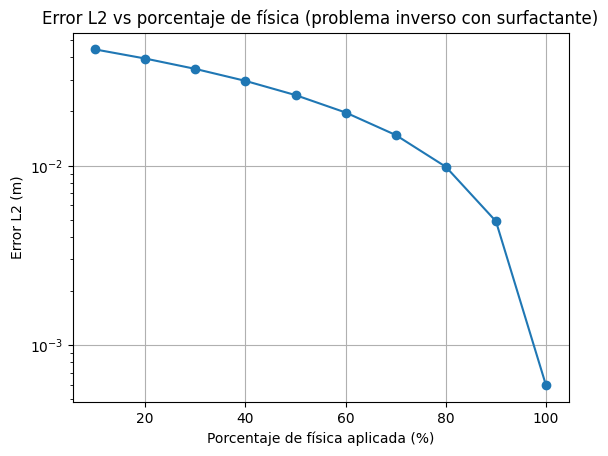

In [32]:
import matplotlib.pyplot as plt

# Datos de la tabla final
pasos = list(range(1, 11))
fisica_pct = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
errores_l2 = [
    4.430679e-02,
    3.941655e-02,
    3.451218e-02,
    2.959502e-02,
    2.466665e-02,
    1.972886e-02,
    1.478380e-02,
    9.834837e-03,
    4.892531e-03,
    5.962053e-04,
]

plt.figure()
plt.plot(fisica_pct, errores_l2, marker='o')
plt.xlabel("Porcentaje de física aplicada (%)")
plt.ylabel("Error L2 (m)")
plt.title("Error L2 vs porcentaje de física (problema inverso con surfactante)")
plt.yscale("log")
plt.grid(True)
plt.show()


In [ ]:
from firedrake import *
import numpy as np
import os
import tempfile
from firedrake.output import VTKFile

# ==========================================
# CONFIGURACIÓN
# ==========================================
results_dir = tempfile.mkdtemp(prefix="firedrake_inverse_smart_")
print(f"Resultados optimizados en: {results_dir}")

mu_val = 1.0
lambda_val = 100.0
gamma_min_val = 0.01
gamma_max_val = 0.20
slope_val = 0.5 

mesh = UnitSquareMesh(32, 32)

# ==========================================
# FASE 1: FORWARD (GENERACIÓN DE DATOS)
# ==========================================
print("\n>>> FASE 1: Forward (Generando paciente)...")
V = VectorFunctionSpace(mesh, "CG", 2) 
Q = FunctionSpace(mesh, "CG", 1)       
Z = V * Q
z = Function(Z)
u, p = split(z)
z_test = TestFunction(Z)

# Cinemática & Energía Forward
d = mesh.geometric_dimension()
I = Identity(d)
F = I + grad(u)
J = det(F)
C = F.T * F
Ic = tr(C)
N = FacetNormal(mesh)
nanson_vec = dot(cofac(F), N)
area_stretch = sqrt(dot(nanson_vec, nanson_vec) + 1.0e-8)
gamma = gamma_min_val + (gamma_max_val - gamma_min_val) * (0.5 + 0.5 * tanh(slope_val * (area_stretch - 1.0)))
psi_bulk = (mu_val/2)*(Ic - 2 - 2*ln(J)) - p*ln(J) + (1.0/(2*lambda_val))*p**2
psi_surf = gamma * area_stretch
Potential = psi_bulk * dx(metadata={"quadrature_degree": 4}) + psi_surf * ds(metadata={"quadrature_degree": 4})

# Solver Forward (Estándar con Newton)
target_disp = -0.15
u_bc_val = Constant(0.0)
bcs = [DirichletBC(Z.sub(0), Constant((0,0)), 3), DirichletBC(Z.sub(0).sub(1), u_bc_val, 4)]

problem_fwd = NonlinearVariationalProblem(derivative(Potential, z, z_test), z, bcs=bcs)
solver_fwd = NonlinearVariationalSolver(problem_fwd, 
                                        solver_parameters={
                                            "snes_type": "newtonls", 
                                            "snes_max_it": 20,
                                            "ksp_type": "preonly", 
                                            "pc_type": "lu", 
                                            "pc_factor_mat_solver_type": "mumps"
                                        })

# Ramping Forward
n_steps = 10
X = SpatialCoordinate(mesh)
for step in range(n_steps):
    current_load = target_disp * ((step + 1) / n_steps)
    u_bc_val.assign(current_load)
    z.sub(0).interpolate(as_vector([0.0, current_load * X[1]])) # Predictor
    solver_fwd.solve()

u_sol_fwd, _ = z.subfunctions
VTKFile(os.path.join(results_dir, "1_forward.pvd")).write(u_sol_fwd)

# Deformar Malla
print("   >>> Deformando malla...")
V_vec = VectorFunctionSpace(mesh, "CG", 1) 
u_interp = Function(V_vec).interpolate(u_sol_fwd)
mesh.coordinates.assign(mesh.coordinates + u_interp)


# ==========================================
# FASE 2: INVERSO ADAPTATIVO (SMART STEPPING)
# ==========================================
print("\n>>> FASE 2: Inverso con Paso Adaptativo y Anderson...")

z_inv = Function(Z)
u_inv, p_inv = split(z_inv)
z_test_inv = TestFunction(Z)

# Cinemática Inversa
f = I + grad(u_inv) 
det_f = det(f)
F_eff = cofac(f).T / det_f 
J_eff = 1.0 / det_f 
C_eff = F_eff.T * F_eff
Ic_eff = tr(C_eff)

# Energía Inversa
psi_iso_inv = (mu_val/2)*(Ic_eff - 2 - 2*ln(J_eff))
psi_vol_inv = -p_inv * ln(J_eff) + (1.0/(2*lambda_val))*p_inv**2
Total_Bulk = (psi_iso_inv + psi_vol_inv) * det_f * dx(metadata={"quadrature_degree": 4})

# Surfactante Inverso
n_spatial = FacetNormal(mesh)
dS_vec = det_f * dot(F_eff.T, n_spatial)
# Aumentamos epsilon ligeramente para evitar NaN en pasos fallidos
area_stretch_inv = 1.0 / sqrt(dot(dS_vec, dS_vec) + 1.0e-6)
gamma_inv = gamma_min_val + (gamma_max_val - gamma_min_val) * (0.5 + 0.5 * tanh(slope_val * (area_stretch_inv - 1.0)))

gamma_factor = Constant(0.0) 
Total_Surf = gamma_factor * gamma_inv * ds(metadata={"quadrature_degree": 4})
Potential_Inv = Total_Bulk + Total_Surf

bcs_inv = [DirichletBC(Z.sub(0), Constant((0,0)), 3)]
problem_inv = NonlinearVariationalProblem(derivative(Potential_Inv, z_inv, z_test_inv), z_inv, bcs=bcs_inv)

# === SOLVER HÍBRIDO ROBUSTO (Anderson + Newton + Backtracking) ===
solver_parameters_smart = {
    # Usamos Anderson (NGMRES) como wrapper externo
    "snes_type": "ngmres",  
    "snes_ngmres_m": 15,            # Memoria aumentada
    "snes_ngmres_restart_it": 10,   # Reiniciar historia cada 10 pasos para limpiar errores
    "snes_ngmres_monitor": None,
    
    # Tolerancias globales
    "snes_max_it": 100,
    "snes_atol": 1e-8,
    "snes_rtol": 1e-6,
    
    # El solver interno es Newton con búsqueda de línea ROBUSTA
    "npc_snes_type": "newtonls",
    "npc_snes_max_it": 3,           # Pocos pasos de Newton por iteración de Anderson
    "npc_snes_linesearch_type": "bt", # Backtracking (bt) o Critical Point (cp) son vitales aquí
    "npc_snes_linesearch_order": 3,   # Interpolación cúbica para el linesearch
    
    # Solver lineal directo
    "npc_ksp_type": "preonly",
    "npc_pc_type": "lu",
    "npc_pc_factor_mat_solver_type": "mumps"
}

solver_inv = NonlinearVariationalSolver(problem_inv, solver_parameters=solver_parameters_smart)
outfile_inv = VTKFile(os.path.join(results_dir, "2_inverse.pvd"))

# === BUCLE ADAPTATIVO ===
# En lugar de "for i in range(20)", usamos un while que avanza según el éxito.
current_gamma = 0.0
target_gamma = 1.0
step_gamma = 0.01  # Paso inicial (5%)
min_step = 1e-6    # Paso mínimo antes de rendirse

# Variable de respaldo para restaurar estado si falla
z_backup = Function(Z)
z_backup.assign(z_inv)

step_count = 0
print(f"   Iniciando relajación adaptativa (Meta: 100% Física)...")

while current_gamma < target_gamma:
    step_count += 1
    
    # Proponer siguiente paso (sin pasarse de 1.0)
    next_gamma = min(current_gamma + step_gamma, target_gamma)
    gamma_factor.assign(next_gamma)
    
    print(f"   [Intento {step_count}] Física: {current_gamma*100:.1f}% -> {next_gamma*100:.1f}% (dt={step_gamma:.3f})", end=" ")
    
    try:
        # Intentar resolver
        solver_inv.solve()
        
        # --- ÉXITO ---
        print("✅ Converged.")
        
        # Actualizar estado base
        current_gamma = next_gamma
        z_backup.assign(z_inv) # Guardar este éxito
        
        # Guardar visualización
        u_sol, _ = z_inv.subfunctions
        u_sol.rename("Desplazamiento_Inverso")
        outfile_inv.write(u_sol)
        
        # Estrategia agresiva: Si fue fácil, aumentar paso ligeramente
        # (Limitamos el paso máx a 0.1 para no pasarnos)
        if step_gamma < 0.1: 
            step_gamma *= 1.2
            
    except Exception as e:
        # --- FALLO ---
        print(f"❌ Falló.")
        # print(f"      Error: {e}") # Descomentar para ver detalle
        
        # Restaurar estado anterior (CRUCIAL)
        z_inv.assign(z_backup)
        
        # Cortar paso a la mitad y reintentar
        step_gamma *= 0.5
        
        if step_gamma < min_step:
            print("   💀 El paso de tiempo es demasiado pequeño. Abortando.")
            break
        
        print(f"      Reintentando con paso reducido: {step_gamma:.4f}")

# ==========================================
# FASE 3: VALIDACIÓN
# ==========================================
print("\n>>> FASE 3: Validación Final...")
X_spatial = SpatialCoordinate(mesh) 
X_rec_func = Function(V_vec, name="Geometria_Recuperada").interpolate(X_spatial + z_inv.sub(0))
VTKFile(os.path.join(results_dir, "3_compare.pvd")).write(X_rec_func)

max_y = np.max(X_rec_func.dat.data[:, 1])
print(f"   Altura recuperada: {max_y:.5f}")

if abs(1.0 - max_y) < 1e-2:
    print("   ✅ Éxito robusto.")
else:
    print("   ⚠️ Se completó pero con error residual.")
    
print(f"Resultados en: {results_dir}")

Resultados optimizados en: /tmp/firedrake_inverse_smart_e7zca7tu

>>> FASE 1: Forward (Generando paciente)...
   >>> Deformando malla...

>>> FASE 2: Inverso con Paso Adaptativo y Anderson...
   Iniciando relajación adaptativa (Meta: 100% Física)...
   [Intento 1] Física: 0.0% -> 0.5% (dt=0.005) picked X_A, obj(X_A) = 3.092411e-16, ||F_A||_2 = 3.092411e-16, obj(X_M) = 3.092225e-16, ||F_M||_2 = 3.092225e-16
✅ Converged.
   [Intento 2] Física: 0.5% -> 1.1% (dt=0.006) picked X_A, obj(X_A) = 3.269252e-16, ||F_A||_2 = 3.269252e-16, obj(X_M) = 3.265049e-16, ||F_M||_2 = 3.265049e-16
✅ Converged.
   [Intento 3] Física: 1.1% -> 1.8% (dt=0.007) picked X_A, obj(X_A) = 3.542724e-16, ||F_A||_2 = 3.542724e-16, obj(X_M) = 3.538395e-16, ||F_M||_2 = 3.538395e-16
✅ Converged.
   [Intento 4] Física: 1.8% -> 2.7% (dt=0.009) picked X_A, obj(X_A) = 3.637156e-16, ||F_A||_2 = 3.637156e-16, obj(X_M) = 3.637087e-16, ||F_M||_2 = 3.637087e-16
✅ Converged.
   [Intento 5] Física: 2.7% -> 3.7% (dt=0.010) picked X_A,

# Elastostática Inversa No Lineal con Fronteras Libres y Cargas Dependientes de la Deformación

Esta es la explicación matemática formal de lo que acabamos de implementar.

## 1. Cinemática del Problema Inverso

En el problema directo (Forward), buscamos la posición actual $x$ dada una referencia $X$.

En el problema inverso, conocemos la configuración deformada espacial $\Omega$ (coordenadas $x$) y buscamos la configuración de referencia (libre de estrés) $\Omega_0$ (coordenadas $X$).

Definimos el mapeo inverso $\xi: \Omega \to \Omega_0$ tal que:

$$X = \xi(x) = x + u_{inv}(x)$$

Donde $u_{inv}$ es el desplazamiento inverso que buscamos.

### Gradiente de Deformación Inverso

El tensor fundamental aquí es el Gradiente de Deformación Inverso ($f$), definido como:

$$f := \nabla_x X = I + \nabla_x u_{inv}$$

Sin embargo, las leyes constitutivas del material (Neo-Hooke) y del surfactante dependen del tensor de deformación físico "Forward" ($F = \nabla_X x$). Por álgebra lineal, sabemos que:

$$F = f^{-1}$$

$$J = \det(F) = \det(f^{-1}) = \frac{1}{\det(f)}$$

En el código, calculamos $F_{eff}$ (que es $F$) usando la matriz de cofactores para estabilidad numérica:

$$F_{eff} = \frac{\text{cof}(f)^T}{\det(f)}$$

---

## 2. Formulación Variacional con Energía de Superficie

Buscamos minimizar la Energía Potencial Total $\Pi$ definida en el dominio espacial $\Omega$:

$$\Pi(u_{inv}) = \underbrace{\int_{\Omega} \Psi_{bulk}(F) \det(f) \, dx}_{\text{Energía Elástica}} + \underbrace{\int_{\partial \Omega} \Psi_{surf}(\lambda) \, ds}_{\text{Energía Surfactante}}$$

### A. Término Volumétrico (Bulk)

La densidad de energía $\Psi_{bulk}$ se define por unidad de volumen de referencia. Para integrarla en la malla actual ($\Omega$), realizamos un cambio de variable usando el determinante del mapeo inverso ($\det f$):

$$dX = \det(f) \, dx$$

### B. Término de Superficie (Surfactante) - La parte difícil

La energía de superficie es $\Psi_{surf} = \gamma(\lambda) \cdot \text{Area}_{actual}$.

Como estamos integrando sobre la malla actual (deformada), el diferencial de área es simplemente $ds$.

El reto es calcular la tensión superficial $\gamma(\lambda)$, que depende del estiramiento $\lambda = \frac{da}{dS}$.

- $da$: Elemento de área actual (conocido)
- $dS$: Elemento de área de referencia (desconocido, es lo que buscamos)

#### Fórmula de Nanson Inversa

Usamos la Fórmula de Nanson Inversa para relacionar las áreas.

La fórmula de Nanson estándar es $da = J F^{-T} N dS$.

Invirtiendo la relación y sustituyendo $F = f^{-1}$ y $J = (\det f)^{-1}$:

$$N dS = \det(f) f^T n da$$

Tomando la norma euclidiana a ambos lados obtenemos la relación de estiramiento escalar:

$$\frac{dS}{da} = \| \det(f) f^T n \|$$

Por lo tanto, el estiramiento local $\lambda$ que alimenta tu ley constitutiva del surfactante es:

$$\lambda = \frac{da}{dS} = \frac{1}{\| \det(f) f^T n \|}$$

Esta ecuación introduce una no-linealidad severa en la frontera, ya que depende de la inversa del gradiente de deformación inverso.

---

## 3. El Problema de Divergencia y la Solución por Homotopía

El solver de Newton intenta encontrar la raíz del residual $R(u_{inv}) = \delta \Pi = 0$.

La convergencia de Newton es cuadrática solo si la estimación inicial $u_0$ está "cerca" de la solución $u^*$.

### ¿Por qué divergió el código original?

Al pasar de la Fase 1 (Forward) a la Fase 2 (Inverse), eliminamos las condiciones de borde de Dirichlet en la parte superior y activamos el surfactante.

Físicamente, el tejido está comprimido. Al soltarlo en el inverso, la energía elástica quiere expandir el tejido, pero el surfactante quiere colapsarlo.

Si aplicamos $\gamma_{total}$ de golpe, el "paisaje de energía" cambia drásticamente. La solución $u=0$ (malla actual) está demasiado lejos del equilibrio relajado. El solver calcula una dirección de búsqueda que lleva a elementos invertidos ($\det f < 0$) o a oscilaciones infinitas.

### La Solución Matemática: Método de Continuación (Ramping)

Transformamos el problema original $R(u) = 0$ en una familia de problemas parametrizados por $t \in [0, 1]$:

$$G(u, t) = R_{bulk}(u) + t \cdot R_{surf}(u) = 0$$

**Para $t=0$:** Resolvemos solo la relajación elástica (sin surfactante). Esto es un problema convexo mucho más fácil. El solver encuentra el equilibrio rápido.

**Para $t \to 1$:** Incrementamos $t$ lentamente ($t_{n+1} = t_n + \Delta t$). Usamos la solución $u(t_n)$ como estimación inicial para $u(t_{n+1})$.

Esto garantiza que, en cada paso $n$, nuestra estimación inicial esté dentro del radio de convergencia del método de Newton para el nuevo estado de energía.

---

## Resumen en Términos de Control Óptimo

Tu script ahora implementa un algoritmo de **Predicción-Corrección con Control de Paso Adaptativo**:

- **Predictor:** Asume que la solución para $\gamma_{n+1}$ es cercana a $\gamma_n$.
- **Corrector (Anderson/Newton):** Minimiza el residual de energía.
- **Control:** Si $\| R \| > \text{tol}$, reduce $\Delta t$ (backtracking) para volver a una zona donde la aproximación cuadrática de la energía sea válida (convexidad local).

Matemáticamente, has estabilizado un sistema rígido (stiff) altamente no lineal mediante continuación homotópica sobre el término de fuerza de superficie.